# Problem 2 - a spooky sampling trick

Again, a Hierarchical Bayesian Model with some data from a simple Gaussian distribution and add on some observational uncertainty. We will make the data look like a distribution of the scare score of monsters working at Monsters Incororated$^{\rm TM}$.

The distribution of the scare scores of the monsters will be defined as:

$S_{\rm i, true} \sim \mathcal{N}(60000, 1000)$.

$S_{i, {\rm obs}} \sim \mathcal{N}(S_{i, {\rm true}}, 1500)$.

Let's set up this data.  This time we will have 1000 points instead of 500!

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


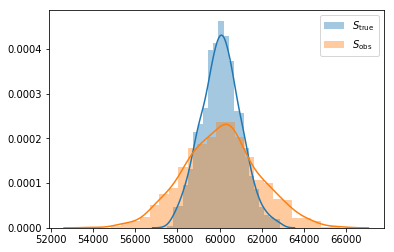

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

N = 1000
Smu = 60000
Ssigma = 1000
S_true = np.random.randn(N) * Ssigma + Smu
sigma_S_obs = np.ones(N) * 1500
S_obs = S_true + np.random.randn(N) * sigma_S_obs

ax = sns.distplot(S_true, label=r'$S_{\rm true}$')
ax = sns.distplot(S_obs, label=r'$S_{\rm obs}$')
ax.legend()

It is immediately obvious, that if we were to try an estimate the spread of scare scores for the employees of Monsters Inc.$^{\rm TM}$ from the observed data just by measuring the standard deviation we would find an overestimate.

In [3]:
print(f'Observed data: mean = {S_obs.mean():.4f}; std = {S_obs.std(ddof=1):.4f}; ' + 
      f'error on mean = {S_obs.std(ddof=1) / N**0.5:.4f}')
print(f'True data: mean = {S_true.mean():.4f}; std = {S_true.std(ddof=1):.4f};  ' +
      f'error on mean = {S_true.std(ddof=1) / N**0.5:.4f}')

Observed data: mean = 60071.0967; std = 1786.7978; error on mean = 56.5035
True data: mean = 60059.4009; std = 936.0180;  error on mean = 29.5995


What we want is a method that takes the measured data and estimates the spread in the true data. We will look at a HBM using latent variables.

Let's jump right in a build an acyclic graph to visualise our problem:

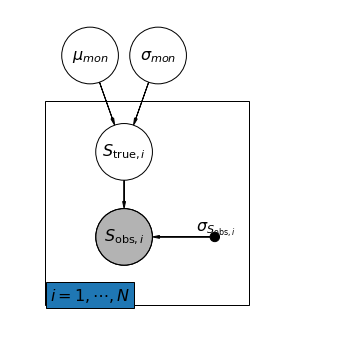

In [4]:
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("mu", r"$\mu_{mon}$", 0.7, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma_{mon}$", 1.3, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("S_true", r"$S_{{\rm true},i}$", 1, 1.75))
# Data.
pgm.add_node(daft.Node("S_obs", r"$S_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("err", r"$\sigma_{S_{{\rm obs},i}}$", 1.8, 1.0, fixed=True, offset=[0.4,0.4]))
# Add in the edges.
pgm.add_edge("mu", "S_true")
pgm.add_edge("sigma", "S_true")
pgm.add_edge("S_true", "S_obs")
pgm.add_edge("err", "S_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.3, 0.5, 1.8, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

The monsters' scare scores are assumed to follow a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$ which are both unknowns.  Each monster in $N$ has an index $i$.  Each monster also has a true scare score, which is an unknown, and an observed scare score which is known with some uncertainty $\sigma_{S_{{\rm obs},i}}$.  We then treat $\mu$, $\sigma$, and $[S_{{\rm true}, 1}, S_{{\rm true}, 2}, ..., S_{{\rm true}, N}]$ as parameters that are to be estimated.

We have the following constraints:

$S_{\rm true} \sim \mathcal{N}(S_{\rm obs}, \sigma_{S_{{\rm obs}}})$.

That is, the true values of the clump K-band magnitude must be consistent with the observed values and their uncertainties.

$S_{\rm true} \sim \mathcal{N}(\mu, \sigma)$.

Which is to say, that the distribution of $S_{\rm true}$ should be consistent with a normal distribution with mean $\mu$ and standard deviation $\sigma$.

We will also add the following priors that represent our exisitng knowledge of the monsters but are designed to be weakly informative:

$\mu \sim \mathcal{N}({60000, 1000})$,

and

$\sigma \sim {\rm Lognormal}(\log(1000), 0.4)$,

Note that this is different from last time as our prior information on $\mu$ is much weaker than before.

We can code this up in stan easily!

The stan code is written here as a string that is passed to the StanModel object.

The code 'sm = pystan.StanModel(model_code=code)' compiles the stan model for us to call later.

We can now run the code.

We can print the fit object to see lots of useful information.  Perhaps most importantly, R_hat gives a measure of convergence.  The closer R_hat is to unity the better.  Experience suggests that all R_hat's less than 1.02 should give reasonable results.

In [9]:
code = '''
data {
    int N;  // N stars
    real Sobs[N];
    real sigmaSobs[N];
}
parameters {
    real mu;
    real<lower = 0> sigma;
    real Struestd[N];
}
transformed parameters {
    real Strue[N];
    for (i in 1:N){
        Strue[i] = Struestd[i] * sigma + mu;
    }
}
model {
    Struestd ~ normal(0, 1);
    Strue ~ normal(Sobs, sigmaSobs);
    mu ~ normal(60000, 1000);
    sigma ~ lognormal(log(1000), 0.4);
}

'''
import pystan
sm2 = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3dcde14fdaaaca13e11952e4a6b62a73 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpaxw_iv5p/stanfit4anon_model_3dcde14fdaaaca13e11952e4a6b62a73_729713772364669446.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [10]:
nchains = 4
data = {'N': N,
       'Sobs': S_obs,
       'sigmaSobs': sigma_S_obs}
fit2 = sm2.sampling(data=data, iter=1000, chains=nchains)

This takes longer to run than before (about 10 seconds on my laptop) but I hope will have convered better.  Let's see.

In [11]:
print(fit2)

Inference for Stan model: anon_model_3dcde14fdaaaca13e11952e4a6b62a73.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu              6.0e4    1.46  56.34  6.0e4  6.0e4  6.0e4  6.0e4  6.0e4   1497    1.0
sigma          962.69    2.48  72.38 816.61 913.68 964.53 1010.9 1107.7    850    1.0
Struestd[1]     -0.04    0.03   0.84  -1.71  -0.59  -0.06    0.5   1.61   1003    1.0
Struestd[2]      0.11    0.02   0.83  -1.55  -0.47   0.12   0.68   1.79   1560    1.0
Struestd[3]     -0.18    0.02   0.83   -1.8  -0.75  -0.16    0.4   1.39   1626    1.0
Struestd[4]      0.25    0.02   0.82  -1.34  -0.32   0.26   0.83   1.83   1575    1.0
Struestd[5]      0.06    0.02   0.83  -1.57  -0.49   0.06    0.6   1.72   1850    1.0
Struestd[6]      0.53    0.02   0.86  -1.12  -0.07   0.53    1.1   2.19   1355    1.0
Struestd[7]      0.38    0.02   0.83  -

Now sigma has converged noticably better.  The trick is that we made the parameters of interest into a bunch of parameters that are normally distributed around zero with standard deviation of unity.  We then make new transformed parameters by multiplying the $\mathcal{N}(0, 1)$ values by sigma and adding mu.  The $\mathcal{N}(0, 1)$ records the order of the stars within the distribution and then this order is transformed into meaningful parameters.  

You see, the order of the monsters in the distribution changes little based on the mu and sigma proposed.  In the old code, to change the mean of the population you would need to change all the values Strue which can be difficult and this caused poor sampling.  In the new code, changing the mean of the population is as simple as changing mu - and this leads to better sampling and convegence.

We can look at the results as before:

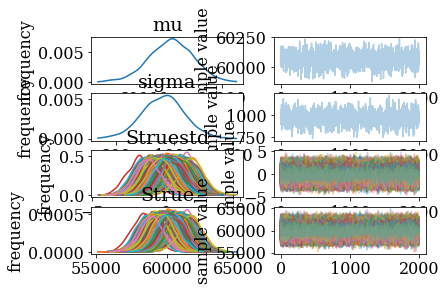

In [12]:
fit2.plot()
plt.show()

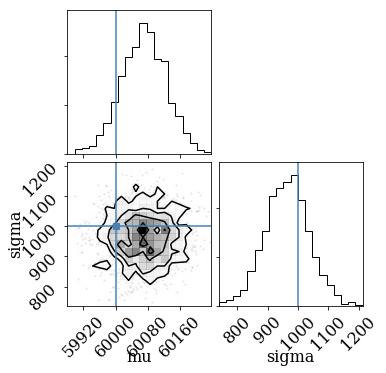

In [13]:
import corner
data = np.vstack([fit2['mu'], fit2['sigma']]).T
corner.corner(data, labels=['mu', 'sigma'], truths=[Smu, Ssigma])
plt.show()